<a href="https://colab.research.google.com/github/TheBuilderHero/Deep_Learning_Road_Mapping/blob/main/True_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import needed Libraries

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download and decompress Data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thebuilderherokota","key":"705cf075e6b380effd0f2494d5e39123"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
100% 3.78G/3.79G [00:34<00:00, 106MB/s] 
100% 3.79G/3.79G [00:34<00:00, 117MB/s]


In [ ]:
#Download Second dataset:
!kaggle datasets download -d ipythonx/tgrs-road

Dataset URL: https://www.kaggle.com/datasets/ipythonx/tgrs-road
License(s): other
 94% 372M/395M [00:01<00:00, 254MB/s]
100% 395M/395M [00:01<00:00, 245MB/s]


In [ ]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip

In [ ]:
!unzip -q /content/tgrs-road.zip

In [ ]:
!ls -l

total 4385012
-rw-r--r-- 1 root root         46 Nov 10  2020 class_dict.csv
-rw-r--r-- 1 root root 4074676823 Nov 10  2020 deepglobe-road-extraction-dataset.zip
-rw-r--r-- 1 root root         74 May  2 19:17 kaggle.json
-rw-r--r-- 1 root root     434416 Nov 10  2020 metadata.csv
drwxr-xr-x 1 root root       4096 May  1 13:20 sample_data
drwxr-xr-x 2 root root      40960 May  2 19:17 test
drwxr-xr-x 5 root root       4096 May  2 19:18 Test
-rw-r--r-- 1 root root  414532592 May 16  2023 tgrs-road.zip
drwxr-xr-x 2 root root     471040 May  2 19:18 train
drwxr-xr-x 5 root root       4096 May  2 19:18 Train
drwxr-xr-x 2 root root      40960 May  2 19:18 valid
drwxr-xr-x 5 root root       4096 May  2 19:18 Validation


## Get min size information associated with picture data

This is not really needed since we know the data is of size 1024 x 1024 but still kept it since it also provides the number of items.

In [ ]:
from PIL import Image
filenames = []
sizes = []
index=1

# This is my path
paths = ["test", "valid", "train", "Test", "Train", "Validation"]

# dirs=directories
for path in paths:
  for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.jpg' in f:
            filenames.append(f)
            filename = root + "/" + f
            sizes.append([Image.open(filename, 'r').size,index])
            index += 1


#print(sizes)
print(max(sizes))
print(min(sizes))

# Define the target size
value = min(sizes)
#print(value[0])
target_size = value[0]  # Specify the new width and height

[(1024, 1024), 8570]
[(1024, 1024), 1]


## Load image data and Rescale pictures to smallest picture size

In [ ]:
#!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-zwe8we6_
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-zwe8we6_
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43609 sha256=f587dfc937756cf49aeead78f9a9e8856bc3fd1e75930a977899aba671c13a64
  Stored in directory: /tmp/pip-ephem-wheel-cache-9fk2cy6t/wheels/72/0b/c7/3f6b26f2d789c712867e02502e1f1b740091f8615f32a9f870
Successfully built Keras-Preprocessing


In [ ]:
# this loads gets all the file names for both the pictures and their masks and puts them into a dataframe.
metadata_df = pd.read_csv(os.path.join("./", 'metadata.csv'))
class_df = pd.read_csv(os.path.join("./", 'class_dict.csv'))
metadata_train_df = metadata_df[metadata_df["split"] == "train"]
metadata_test_df = metadata_df[metadata_df["split"] == "test"]

#remove the plit column now that it is not needed:
metadata_train_df.drop("split",inplace=True,axis=1)
metadata_test_df.drop("split",inplace=True,axis=1)

#test does not need the mask path since it is gonna generate them:
metadata_test_df.drop("mask_path",inplace=True,axis=1)

#fix indexing:
metadata_train_df = metadata_train_df.reset_index()
metadata_test_df = metadata_test_df.reset_index()

# get full path to the images
metadata_train_df['sat_image_path'] = metadata_train_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_train_df['mask_path'] = metadata_train_df['mask_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_test_df['sat_image_path'] = metadata_test_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))

<ipython-input-15-d3138a5cf9b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train_df.drop("split",inplace=True,axis=1)
<ipython-input-15-d3138a5cf9b2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("split",inplace=True,axis=1)
<ipython-input-15-d3138a5cf9b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("mask_path",inplace=True,axis=1)


#### Shuffle and split data

In [ ]:
metadata_train_df = metadata_train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
valid_df = metadata_train_df.sample(frac=0.2,random_state=42)
train_df = metadata_train_df.drop(valid_df.index)

#### Get class data

In [ ]:
class_names = class_df["name"].tolist()

In [ ]:
RGB_values = class_df[["r","g","b"]].values.tolist()

In [ ]:
Class_Type = ['background', 'road']

In [ ]:
# Makes the class values 0 and 1
Class_Indices = [class_names.index(cls.lower()) for cls in Class_Type]

In [ ]:
Class_RGB_Values = np.array(RGB_values)[Class_Indices]
# Creates a matrix of class RGB values

## Image Loading and Processing

In [ ]:
import cv2
import pandas as pd
import tensorflow as tf

data_size = [3000,256,256] # size of images reduced by factor of 4 and we are taking the first 3000 images.

reduced_data = train_df[0:data_size[0]].reset_index(drop=True)

sat_images = []
mask_images = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images.append(img)
    mask_images.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [ ]:
reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

sat_images_valid = []
mask_images_valid = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images_valid.append(img)
    mask_images_valid.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [ ]:
#print(sat_images[0])
#print(mask_images[0])

### Get some Augmented data

In [ ]:
import random
def augment_data(sat_images,mask_images):
    augmented_sat_images = []
    augmented_mask_images = []
    for img, mask in zip(sat_images,mask_images):

      #randomly augment them over the x axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,1))
          augmented_mask_images.append(cv2.flip(mask,1))

      #randomly augment them over the y axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,0))
          augmented_mask_images.append(cv2.flip(mask,0))
        #A flag to specify how to flip the array; 0 means flipping around the x-axis and positive value (for example, 1) means flipping around y-axis. Negative value (for example, -1) means flipping around both axes. Return Value: It returns an image.
      #randomly augment them over the x and y axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,-1))
          augmented_mask_images.append(cv2.flip(mask,-1))
      #randomly augement them by rotating them 180 degrees (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.rotate(img,cv2.ROTATE_180))
          augmented_mask_images.append(cv2.rotate(mask,cv2.ROTATE_180))
      #randomly augement them by rotating them 90 degrees (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE))
          augmented_mask_images.append(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE))
      #zoom into image by 10%
        if random.uniform(0,100) < 10:
          aug_img = cv2.resize(img, (230, 230))
          aug_mask = cv2.resize(mask, (230, 230))
          aug_img = cv2.resize(aug_img, (256, 256))
          aug_mask = cv2.resize(aug_mask, (256, 256))

          augmented_sat_images.append(aug_img)
          augmented_mask_images.append(aug_mask)

        #add all images to the array itself.
        augmented_sat_images.append(img)
        augmented_mask_images.append(mask)


    return augmented_sat_images,augmented_mask_images

#Add augmented images into the data:
sat_images,mask_images = augment_data(sat_images,mask_images)


##Round off all the data to make sure we do not have float values

In [ ]:
# Tried this but dont think the results were better
#mask_images = np.round(mask_images)

### Getting some random samples of the data

Image shape: 4778, Mask shape: 4778
Image ID: 2094


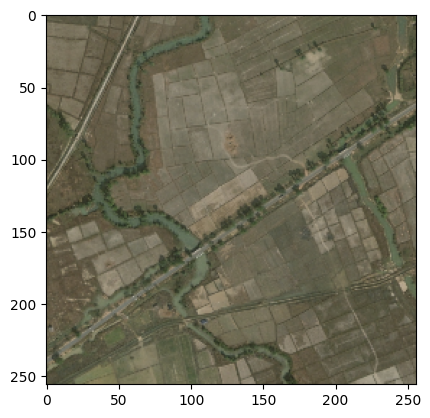

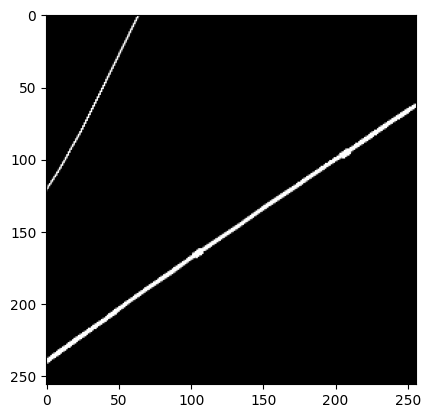

Image shape: 4778, Mask shape: 4778
Image ID: 315


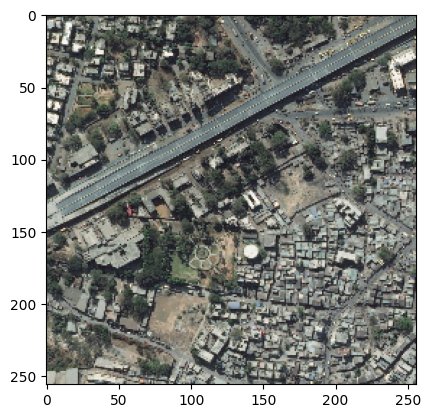

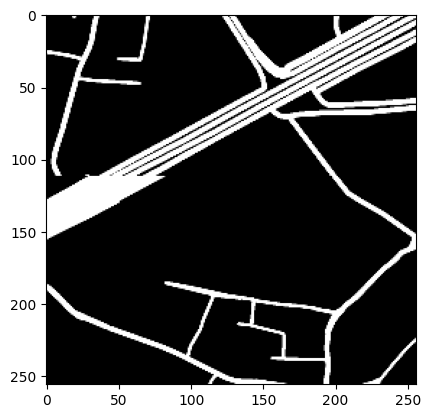

Image shape: 4778, Mask shape: 4778
Image ID: 3549


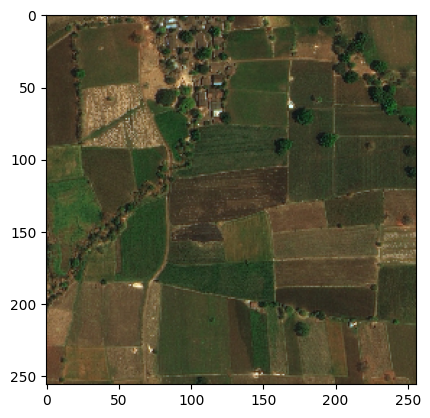

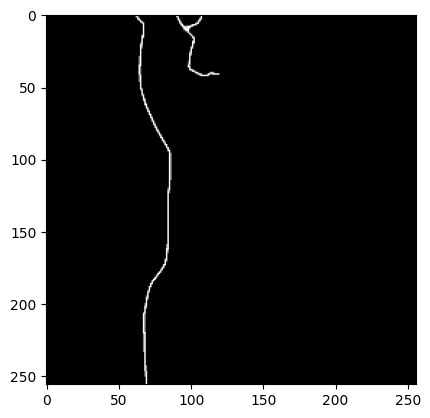

Image shape: 4778, Mask shape: 4778
Image ID: 2076


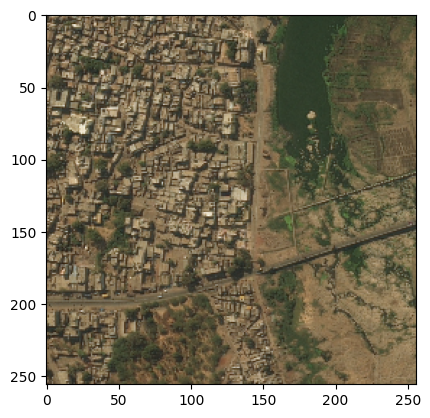

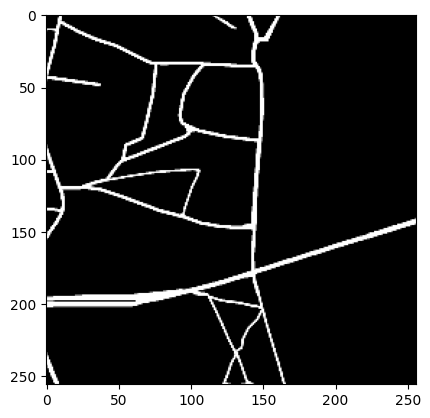

Image shape: 4778, Mask shape: 4778
Image ID: 265


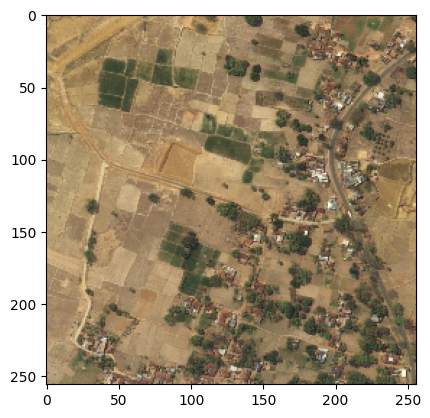

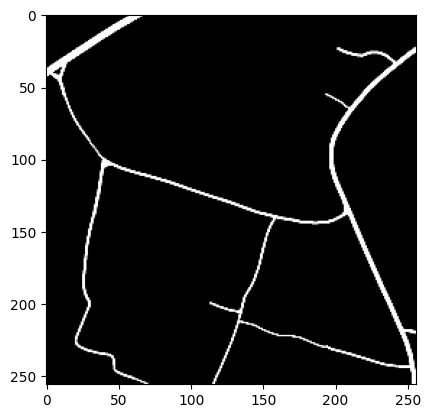

In [ ]:
import random
for i in range(5):
  # Setup the dataset # Note that the class_rgb_values is being set to the RGB values of the input classes values.
  random_idx = random.randint(0, len(sat_images)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(sat_images)}, Mask shape: {len(mask_images)}")
  print(f"Image ID: {random_idx}")
  import matplotlib.pyplot as plt
  plt.imshow(sat_images[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = mask_images[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  #plt.imshow(mask)
  #plt.show()

## Build the model

In [ ]:
model = Sequential()
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape = (data_size[1],data_size[2],3), padding='same' ))
print(model.output_shape)
print(model.input_shape)
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' , padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
#model.add( MaxPool2D(2, 2) )


model.add(Dropout(0.10))
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
model.add(BatchNormalization())

model.add(Dropout(0.10))
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
model.add(BatchNormalization())

#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 7, 7 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))

#duplicated for complexity
model.add( Conv2D( 128, ( 7, 7 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ))
model.add(BatchNormalization())
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))


model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu' , padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', padding='same' ) )
#model.add( Flatten() )
#model.add( Dense( 512, activation = 'relu' ) )
#model.add( Dense( 256, activation = 'sigmoid' ) )


model.add( Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding='same' ) )

(None, 256, 256, 32)
(None, 256, 256, 3)


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define the filepath for saving the weights
filepath = "model_weights.h5"

# Load the saved weights into the model
#model.load_weights("model_weights.h5")

# Define a ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
EarlyStopping = EarlyStopping(monitor='val_loss', patience=5)

## Compile the model and overfit it to the Data

In [ ]:
sat_images = np.array(sat_images)
mask_images = np.array(mask_images)

sat_images_reshaped = sat_images.reshape((-1, 256, 256, 3))
mask_images_reshaped = mask_images.reshape((-1, 256, 256, 1))

In [ ]:
model.compile( optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [ 'accuracy' ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     204928    
                                                        

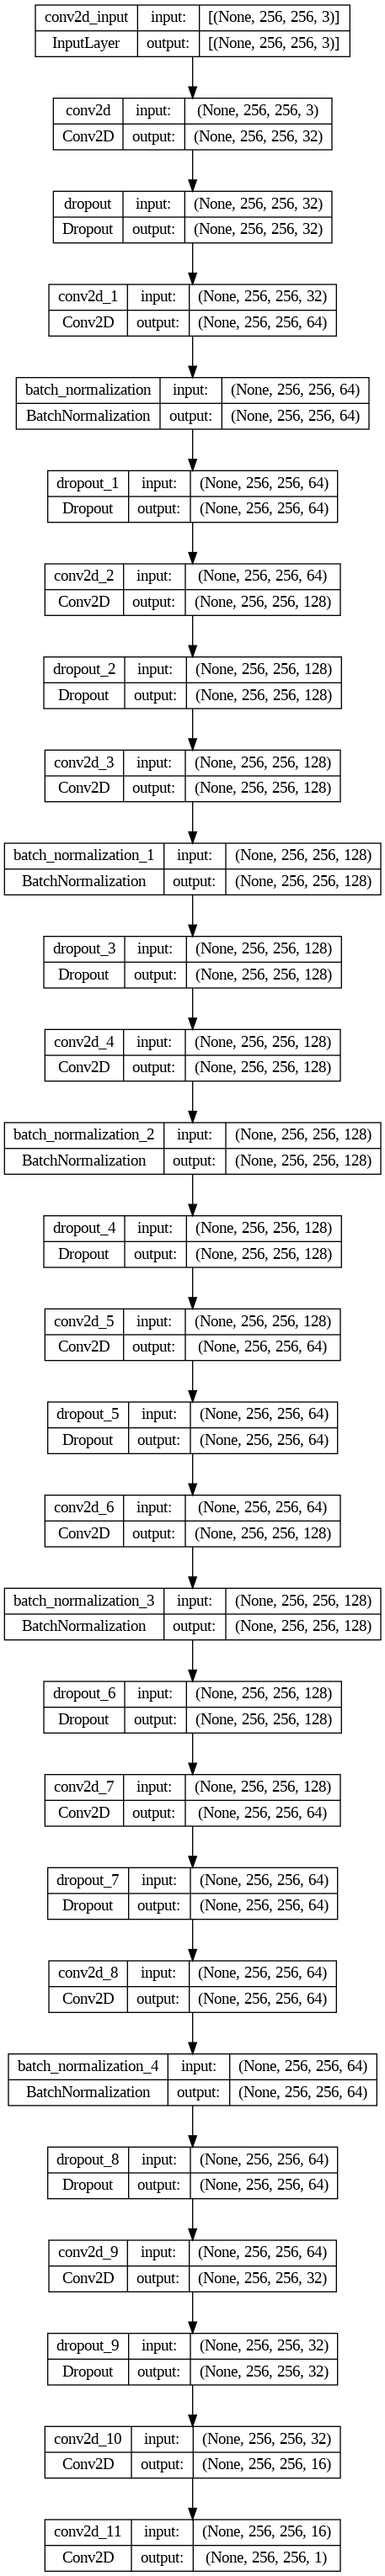

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Load the saved weights into the model
#model.load_weights("model_weights.h5")

In [ ]:
#train_generator_one_hot.element_spec
history = model.fit(sat_images,mask_images, batch_size=2, epochs = 30, callbacks=[checkpoint,EarlyStopping], validation_split=0.2)

Epoch 1/30
1911/1911 [==============================] - 304s 148ms/step - loss: 53.8755 - accuracy: 0.8297 - val_loss: 50.2557 - val_accuracy: 0.9469
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1911/1911 [==============================] - 283s 148ms/step - loss: 49.1956 - accuracy: 0.9544 - val_loss: 47.4344 - val_accuracy: 0.9566
Epoch 3/30
1911/1911 [==============================] - 282s 148ms/step - loss: 47.9101 - accuracy: 0.9563 - val_loss: 46.7451 - val_accuracy: 0.9586
Epoch 4/30
1911/1911 [==============================] - 281s 147ms/step - loss: 47.0942 - accuracy: 0.9575 - val_loss: 46.1143 - val_accuracy: 0.9610
Epoch 5/30
1911/1911 [==============================] - 280s 147ms/step - loss: 46.6483 - accuracy: 0.9580 - val_loss: 45.7457 - val_accuracy: 0.9598
Epoch 6/30
1911/1911 [==============================] - 280s 146ms/step - loss: 46.1606 - accuracy: 0.9586 - val_loss: 46.6099 - val_accuracy: 0.9602
Epoch 7/30
1911/1911 [==============================] - 279s 146ms/step - loss: 45.9195 - accuracy: 0.9590 - val_loss: 46.0592 - val_accuracy: 0.9624
Epoch 8/30
1911/1911 [==============================] - 279s 146ms/step - loss: 45.6119 - accuracy: 0.9593 - va

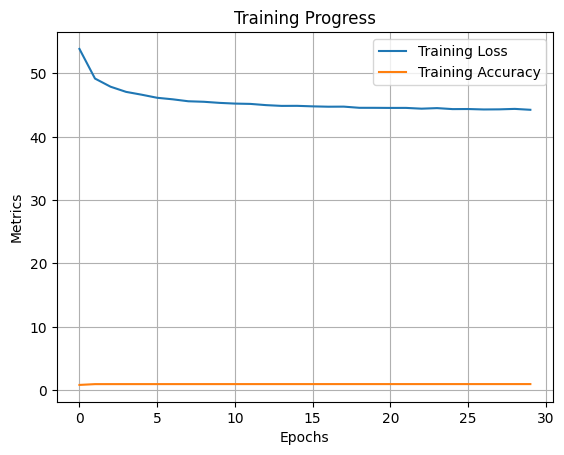

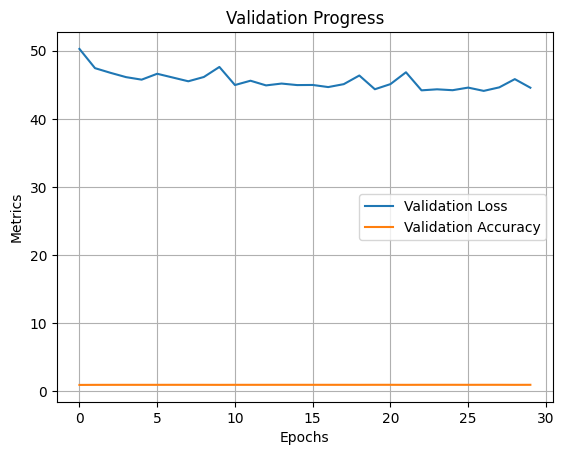

In [ ]:
# Plotting training loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation loss and accuracy
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Progress')
plt.legend()
plt.grid(True)
plt.show()

### Get 4 metrics

In [ ]:
# Load the saved weights into the model
model.load_weights("model_weights.h5")

In [ ]:
valid_df.head()

index  image_id          sat_image_path                mask_path
239    5572     90063   ./train/90063_sat.jpg   ./train/90063_mask.png
1119   6073    974843  ./train/974843_sat.jpg  ./train/974843_mask.png
2215   5808    936795  ./train/936795_sat.jpg  ./train/936795_mask.png
2500   2221    415246  ./train/415246_sat.jpg  ./train/415246_mask.png
5783   4691    771440  ./train/771440_sat.jpg  ./train/771440_mask.png

In [ ]:
import numpy as np

I_stats = [] # empty list of sat maps
Y_stats = [] # empty list of true labels
P_stats = [] # empty list of predictions
Y_base_states = [] # empty list of all zeros arrays which should help us find out model's baseline

I = [] # empty list of sat maps
Y = [] # empty list of true labels
P = [] # empty list of predictions


data_size = [len(valid_df),256,256]

reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    img = img.reshape((-1, 256, 256, 3))

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.


    pred = model.predict(img, verbose = 0)  # Make predictions for the batch

    #print(mask.shape)
    #print(pred.shape)

    temp_mask = mask[:,:,0].reshape((-1, 256, 256, 1))

    I.extend(img)
    Y.extend(temp_mask)# this is because its a binary mask and img is present in channel 0
    P.extend(pred)

    mask = mask[:,:,0].reshape((256 * 256))
    pred_baseline = np.zeros(mask.shape)
    pred = pred.reshape((256 * 256))

    #acc = np.sum(mask == pred) / np.size(mask)
    #pre = np.sum(mask * pred) / np.sum(pred)
    #rec = np.sum(mask * pred) / np.sum(mask)
    #f1 = 2 * pre * rec / (pre + rec)


    I_stats.extend(img)
    Y_stats.extend(mask)# this is because its a binary mask and img is present in channel 0
    Y_base_states.extend(pred_baseline)
    P_stats.extend(pred)
    #break;

#print("Accuracy:", acc)
#print("Precision:", pre)
#print("Recall:", rec)
#print("F1-score:", f1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
Y_temp = np.array(Y).round()
P_temp = np.array(P).round()
I_temp = np.array(I)
#difference =  np.array(np.round(P_temp) - np.round(Y_temp))
#image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
#print(f"Image shape: {len(I_temp)}, Mask shape: {len(P_temp)}")

#plt.imshow(difference, cmap='gray')
#plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
#plt.imshow(P_temp, cmap='gray')
#plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
#plt.imshow(Y_temp, cmap='gray')
#plt.show()


print(len(Y_temp.flatten()))
print(len(Y_temp.flatten()) - Y_temp.sum())
print((len(Y_temp.flatten()) - Y_temp.sum())/len(Y_temp.flatten()))
# baseline is 59174/65536 = 90%
base = (len(Y_temp.flatten()) - Y_temp.sum())/len(Y_temp.flatten())

actual = accuracy_score(Y_temp.flatten().round(), P_temp.flatten().round())
print("Base Accuracy: ", base)
print("Prediction Accuracy: ", actual)
print("Base vs Prediction difference: ", "%.4f" % ((actual - base)*100), "percent")


#truevalues = Y_temp.flatten()
#predvalues = P_temp.flatten().round()
#predvalues = np.full_like(truevalues, 0)

#print(len(truevalues))

#x = truevalues[:253]
#print(len(predvalues))
# accuracyscore = accuracy_score(x, x)
#print(accuracyscore)

#print(truevalues[252:255])


81592320
77928023.0
0.9550901727025288
Base Accuracy:  0.9550901727025288
Prediction Accuracy:  0.9689540020433296
Base vs Prediction difference:  1.3864 percent


## Samples of predictions vs True and their Accuracies

[0. 1.]


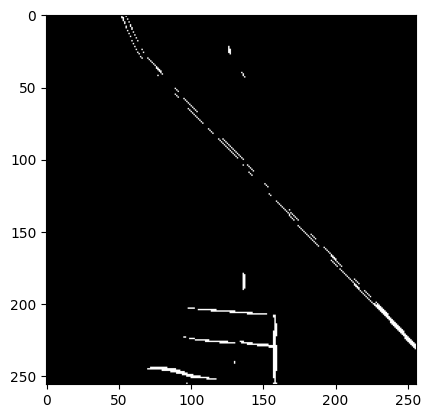

Image ID: 0
Single Image Accuracy:  0.9888  Precent
Base Image Accuracy:  0.9866  Precent


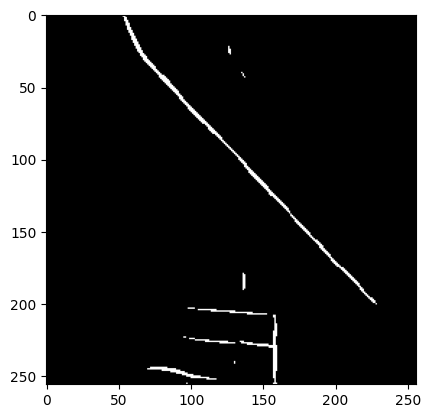

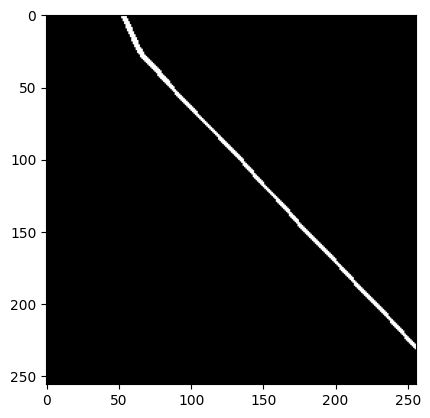

[0. 1.]


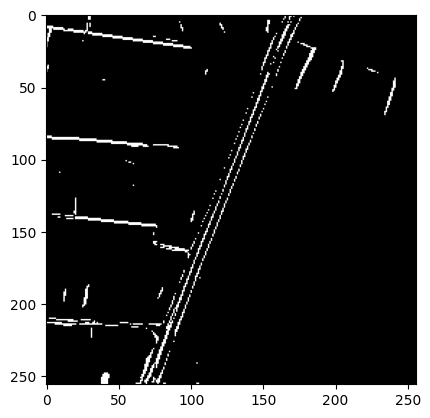

Image ID: 1
Single Image Accuracy:  0.9719  Precent
Base Image Accuracy:  0.9474  Precent


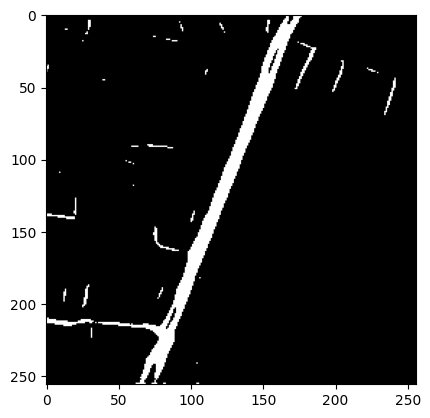

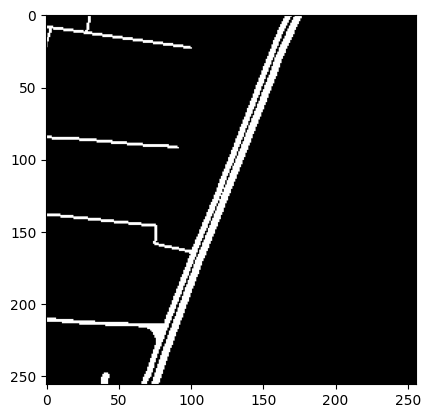

[0. 1.]


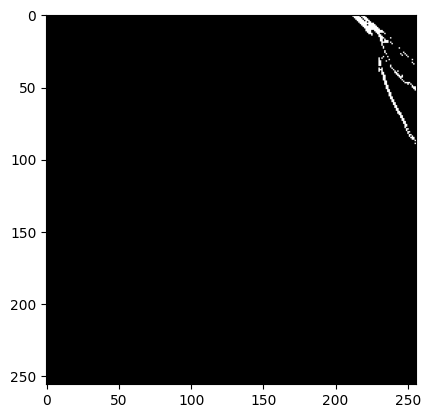

Image ID: 2
Single Image Accuracy:  0.9952  Precent
Base Image Accuracy:  0.9928  Precent


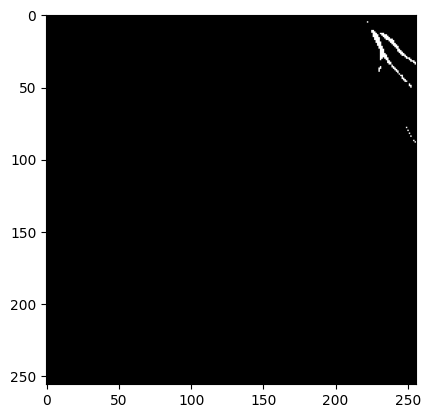

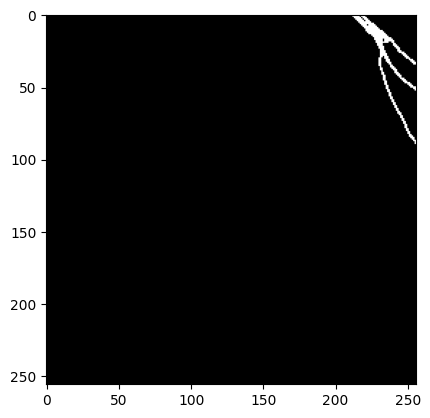

[0. 1.]


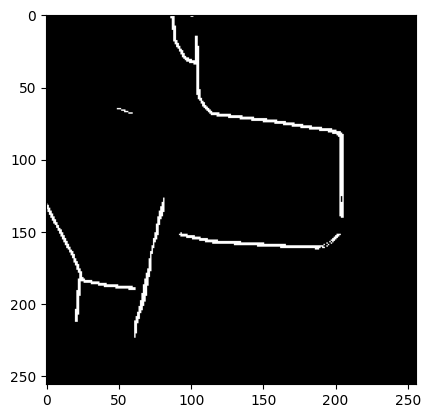

Image ID: 3
Single Image Accuracy:  0.9790  Precent
Base Image Accuracy:  0.9825  Precent


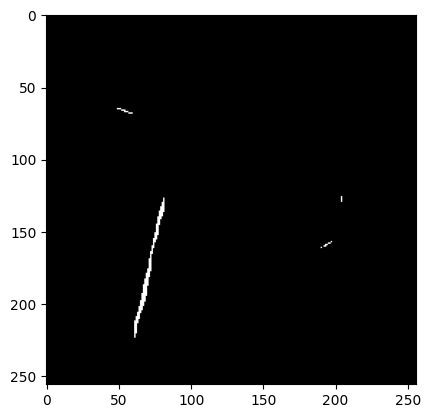

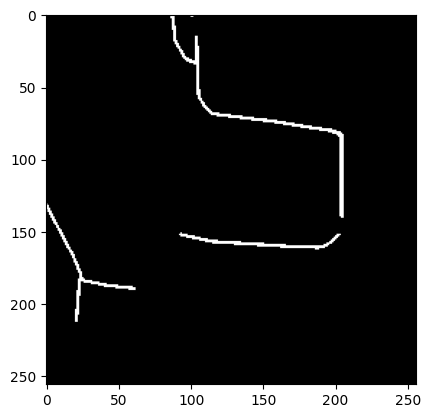

[0. 1.]


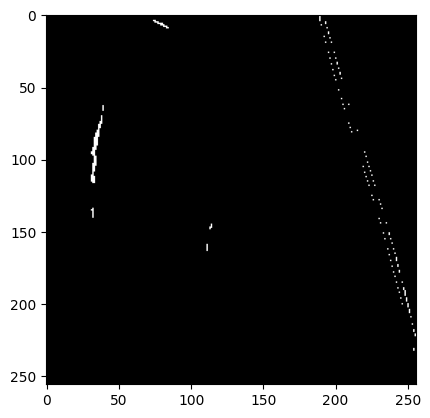

Image ID: 4
Single Image Accuracy:  0.9961  Precent
Base Image Accuracy:  0.9859  Precent


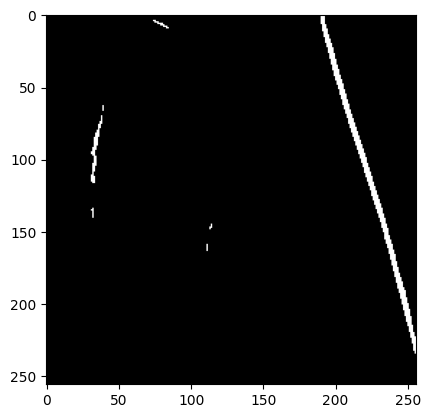

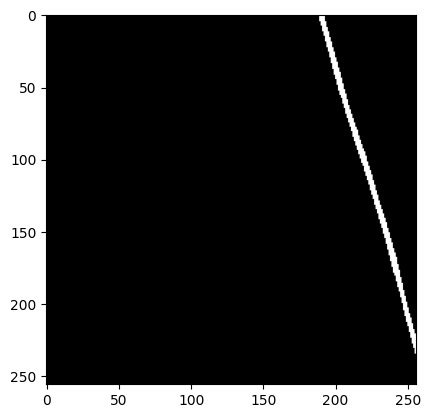

In [ ]:
for i in range(5):
  difference =  np.array(np.abs(np.round(P_temp[i]) - np.round(Y_temp[i])))

  print(np.unique(difference))

  plt.imshow(difference, cmap='gray')
  plt.show()
  print(f"Image ID: {i}")
  print("Single Image Accuracy: ", "%.4f" % accuracy_score(Y_temp[i].flatten().round(), P_temp[i].flatten().round()), " Precent")
  base = (len(Y_temp[i].flatten()) - Y_temp[i].sum())/len(Y_temp[i].flatten())
  print("Base Image Accuracy: ", "%.4f" % base, " Precent")

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  plt.imshow(np.round(P_temp[i]), cmap='gray')
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  plt.imshow(np.round(Y_temp[i]), cmap='gray')
  plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_stats = np.array(Y).flatten().round()
P_stats = np.array(P).flatten().round()

# Calculate evaluation metrics
# For multi-class segmentation
accuracy = accuracy_score(Y_stats, P_stats)
precision = precision_score(Y_stats, P_stats.flatten(), average='weighted')
recall = recall_score(Y_stats, P_stats.flatten(), average='weighted')
f1 = f1_score(Y_stats, P_stats.flatten(), average='weighted')

# Calculate Base evaluation metrics
# For multi-class segmentation
#base_accuracy = accuracy_score(Y_base_stats, P_stats)
#base_precision = precision_score(Y_base_stats, P_stats.flatten(), average='weighted')
#base_recall = recall_score(Y_base_stats, P_stats.flatten(), average='weighted')
#base_f1 = f1_score(Y_base_stats, P_stats.flatten(), average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

#print("Base Accuracy:", base_accuracy)
#print("Base Precision:", base_precision)
#print("Base Recall:", base_recall)
#print("Base F1-score:", base_f1)

#print("Improvement Accuracy:", accuracy - base_accuracy)
#print("Improvement Precision:", precision - base_precision)
#print("Improvement Recall:", recall - base_recall)
#print("Improvement F1-score:", f1 - base_f1)

#print(Y_stats)
#print(P_stats)


Accuracy: 0.9689540020433296
Precision: 0.9652481134475734
Recall: 0.9689540020433296
F1-score: 0.9640090873607656


Image shape: 1245, Mask shape: 1245
Image ID: 822


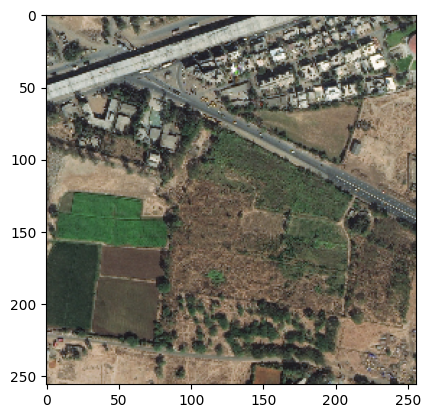

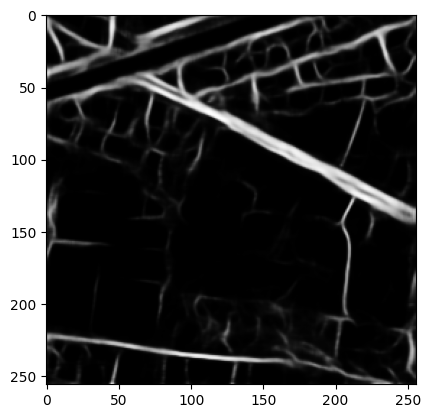

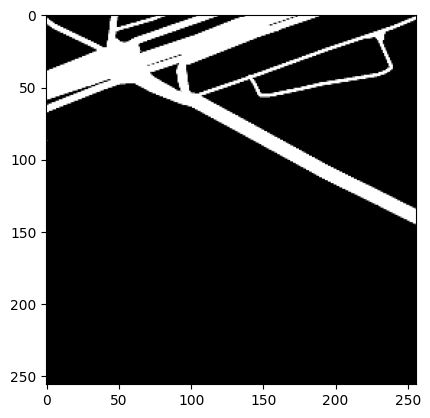

Image shape: 1245, Mask shape: 1245
Image ID: 645


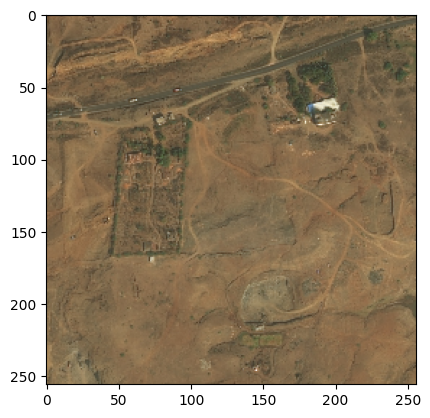

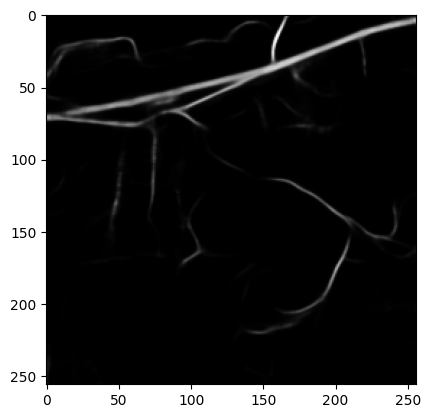

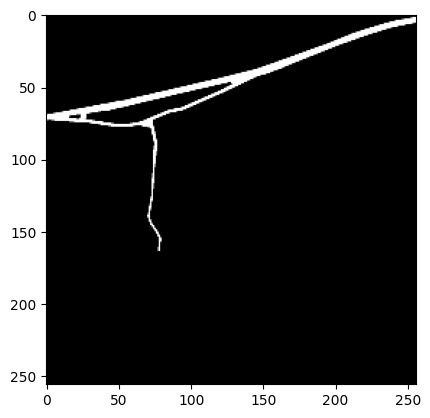

Image shape: 1245, Mask shape: 1245
Image ID: 729


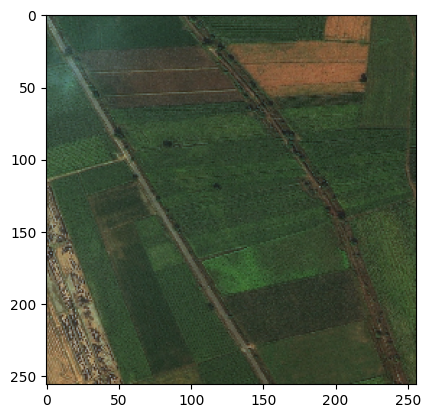

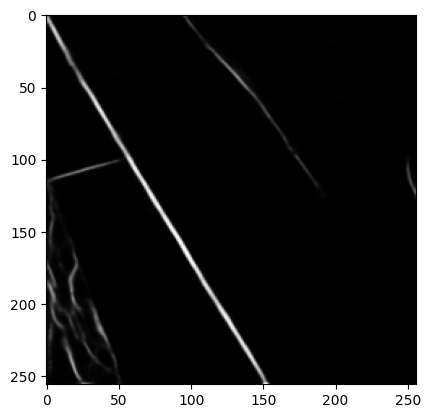

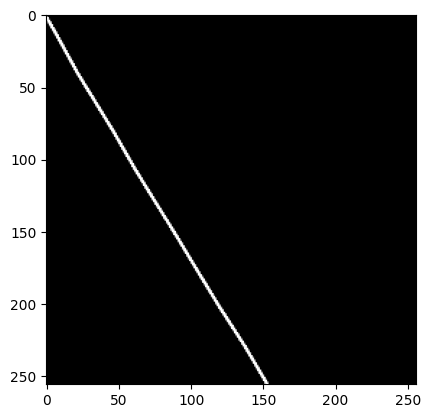

Image shape: 1245, Mask shape: 1245
Image ID: 217


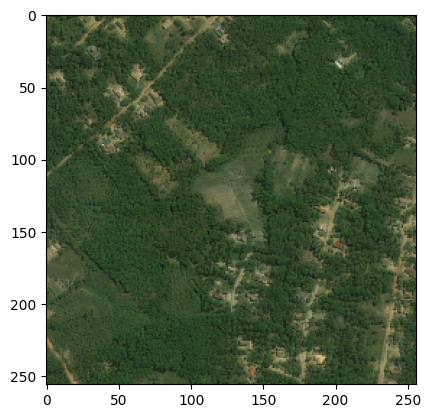

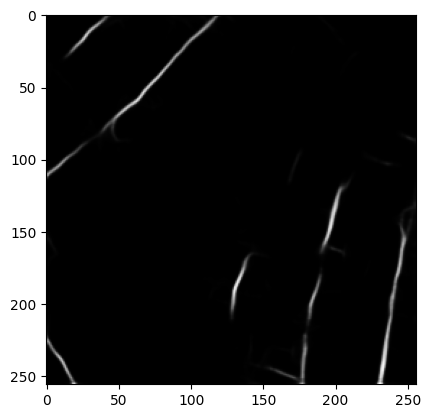

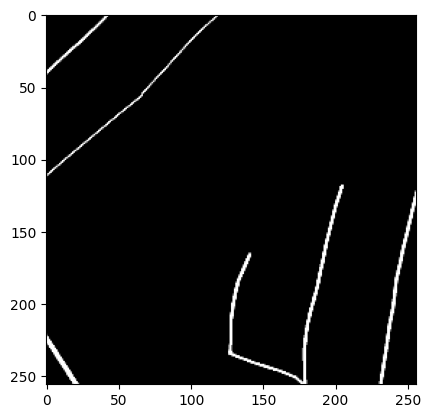

Image shape: 1245, Mask shape: 1245
Image ID: 629


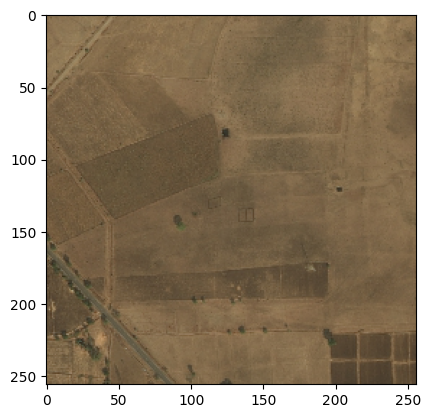

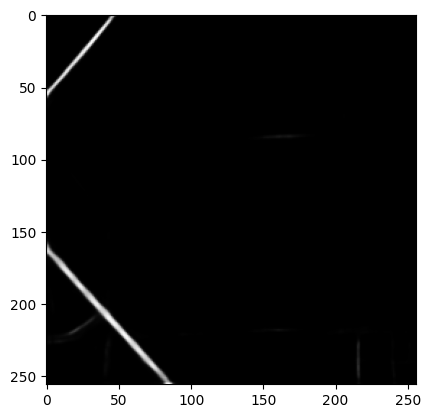

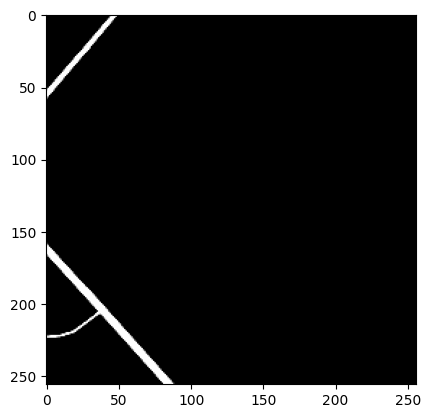

In [ ]:
for i in range(5):
  random_idx = random.randint(0, len(I)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(I)}, Mask shape: {len(P)}")
  import matplotlib.pyplot as plt
  print(f"Image ID: {random_idx}")
  plt.imshow(I[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = P[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = Y[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

## Convert to HTML this notebook

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/True_Final_Project.ipynb

[NbConvertApp] Converting notebook /content/True_Final_Project.ipynb to html
[NbConvertApp] Writing 5740818 bytes to /content/True_Final_Project.html
